d-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px; height: 163px">
</div>

# Building a Machine Learning Model
## Module 4, Lesson 5

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) In this lesson you:
* Build a Machine Learning model using scikit-learn
* Predict the response time to an incident given different features

In [0]:
%run ../Includes/Classroom-Setup

Data mounted to /mnt/davis ...

## Load Data

We are going to build a model on a subset of our data.

In [0]:
%sql
USE DATABRICKS;

CREATE TABLE IF NOT EXISTS fireCallsClean
USING parquet
OPTIONS (
  path "/mnt/davis/fire-calls/fire-calls-clean.parquet"
)

## Timestamp

Let's convert our `Response_DtTm` and `Received_DtTm` into timestamp types.

In [0]:
%sql
CREATE OR REPLACE VIEW time AS (
  SELECT *, unix_timestamp(Response_DtTm, "MM/dd/yyyy hh:mm:ss a") as ResponseTime, 
            unix_timestamp(Received_DtTm, "MM/dd/yyyy hh:mm:ss a") as ReceivedTime
  FROM fireCallsClean
)

## Time Delay

Now that we have our `Response_DtTm` and `Received_DtTm` as timestamp types, we can compute the difference in minutes between the two.

In [0]:
%sql
CREATE OR REPLACE VIEW timeDelay AS (
  SELECT *, (ResponseTime - ReceivedTime)/60 as timeDelay
  FROM time
)

Uh oh! We have some records with a negative time delay, and some with very extreme values. We will filter out those records.

In [0]:
%sql
SELECT timeDelay, Call_Type, Fire_Prevention_District, `Neighborhooods_-_Analysis_Boundaries`, Number_of_Alarms, Original_Priority, Unit_Type
FROM timeDelay 
WHERE timeDelay < 0

timeDelay,Call_Type,Fire_Prevention_District,Neighborhooods_-_Analysis_Boundaries,Number_of_Alarms,Original_Priority,Unit_Type
-58.233333333333334,Structure Fire,5,Hayes Valley,1,3,ENGINE
-49.333333333333336,Medical Incident,1,Financial District/South Beach,1,3,TRUCK
-56.016666666666666,Medical Incident,2,Potrero Hill,1,3,ENGINE
-57.416666666666664,Structure Fire,4,Tenderloin,1,3,TRUCK
-56.06666666666667,Medical Incident,2,Tenderloin,1,1,MEDIC
-1.2,Alarms,3,Mission Bay,1,3,ENGINE


Great! Our data is prepped and ready to be used to build a model!

In [0]:
%sql
SELECT timeDelay, Call_Type, Fire_Prevention_District, `Neighborhooods_-_Analysis_Boundaries`, Number_of_Alarms, Original_Priority, Unit_Type
FROM timeDelay 
WHERE timeDelay < 15 AND timeDelay > 0

timeDelay,Call_Type,Fire_Prevention_District,Neighborhooods_-_Analysis_Boundaries,Number_of_Alarms,Original_Priority,Unit_Type
2.3666666666666667,Traffic Collision,10,Bayview Hunters Point,1,2,MEDIC
2.433333333333333,Medical Incident,2,South of Market,1,2,ENGINE
3.816666666666667,Medical Incident,2,Mission,1,1,MEDIC
7.75,Medical Incident,10,Portola,1,3,ENGINE
0.8833333333333333,Structure Fire,8,Sunset/Parkside,1,3,ENGINE
1.7333333333333334,Medical Incident,3,South of Market,1,2,PRIVATE
3.7666666666666666,Medical Incident,2,Mission,1,1,PRIVATE
4.0,Medical Incident,8,Sunset/Parkside,1,2,MEDIC
3.566666666666667,Medical Incident,2,Tenderloin,1,3,MEDIC
3.5166666666666666,Medical Incident,9,Outer Mission,1,3,MEDIC


## Convert to Pandas DataFrame

We are going to convert our Spark DataFrame to a Pandas DataFrame to build a scikit-learn model. Although we could use SparkML to train models, a lot of data scientists start by building their models using Pandas and Scikit-Learn.

We will also enable [Apache Arrow](https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html) for faster transfer of data from Spark DataFrames to Pandas DataFrames.

In [0]:
%python
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

pdDF = sql("""SELECT timeDelay, Call_Type, Fire_Prevention_District, `Neighborhooods_-_Analysis_Boundaries`, Number_of_Alarms, Original_Priority, Unit_Type
              FROM timeDelay 
              WHERE timeDelay < 15 AND timeDelay > 0""").toPandas()

/databricks/python/lib/python3.6/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
 warnings.warn("pyarrow.open_stream is deprecated, please use "

## Visualize

Let's visualize the distribution of our time delay.

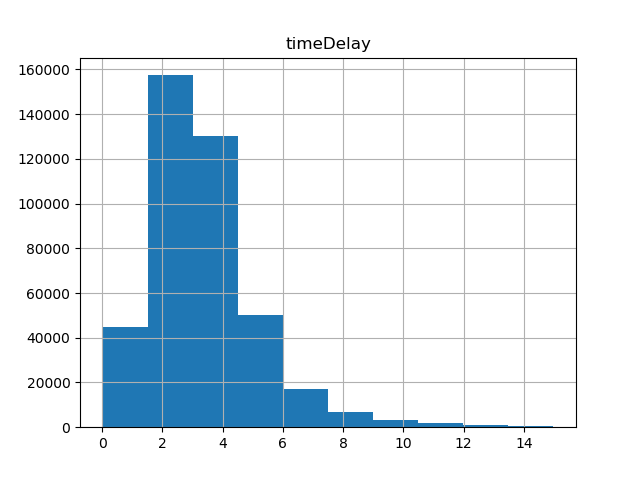

In [0]:
%python
import pandas as pd
import numpy as np

fig = pdDF.hist(column="timeDelay")[0][0]
display(fig.figure)

## Train-Test Split

In this notebook we are going to use 80% of our data to train our model, and 20% to test our model. We set a [random_state](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for reproducibility.

In [0]:
%python
from sklearn.model_selection import train_test_split

X = pdDF.drop("timeDelay", axis=1)
y = pdDF["timeDelay"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Model

Before we get started building our linear regression model, let's establish our baseline RMSE on our test dataset by always predicting the average value. Here, we are going to take the square root of the [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [0]:
%python
from sklearn.metrics import mean_squared_error
import numpy as np

avgDelay = np.full(y_test.shape, np.mean(y_train), dtype=float)

print("RMSE is {0}".format(np.sqrt(mean_squared_error(y_test, avgDelay))))

RMSE is 1.8348773381102907

## Build Linear Regression Model

Great! Now that we have established a baseline, let's use scikit-learn's [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) API to build a linear regression model.

Our pipeline will have two steps: 
0. [One Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder): this converts our categorical features into numeric features by creating a dummy column for each value in that category. 
    * For example, if we had a column called `Animal` with the values `Dog`, `Cat`, and `Bear`, the corresponding one hot encoding representation for Dog would be: `[1, 0, 0]`, Cat: `[0, 1, 0]`, and Bear: `[0, 0, 1]`
0. [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model: find the line of best fit for our training data

In [0]:
%python
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

ohe = ("ohe", OneHotEncoder(handle_unknown="ignore"))
lr = ("lr", LinearRegression(fit_intercept=True, normalize=True))

pipeline = Pipeline(steps = [ohe, lr]).fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

You can see the corresponding one hot encoded feature names below.

In [0]:
%python
print(pipeline.steps[0][1].get_feature_names())

['x0_Administrative' 'x0_Aircraft Emergency' 'x0_Alarms'
 'x0_Assist Police' 'x0_Citizen Assist / Service Call'
 'x0_Confined Space / Structure Collapse' 'x0_Electrical Hazard'
 'x0_Elevator / Escalator Rescue' 'x0_Explosion'
 'x0_Extrication / Entrapped (Machinery, Vehicle)' 'x0_Fuel Spill'
 'x0_Gas Leak (Natural and LP Gases)' 'x0_HazMat' 'x0_High Angle Rescue'
 'x0_Industrial Accidents' 'x0_Marine Fire' 'x0_Medical Incident'
 'x0_Mutual Aid / Assist Outside Agency' 'x0_Odor (Strange / Unknown)'
 'x0_Oil Spill' 'x0_Other' 'x0_Outside Fire'
 'x0_Smoke Investigation (Outside)' 'x0_Structure Fire'
 'x0_Suspicious Package' 'x0_Traffic Collision' 'x0_Train / Rail Incident'
 'x0_Vehicle Fire' 'x0_Water Rescue' 'x0_Watercraft in Distress' 'x1_1'
 'x1_10' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x1_7' 'x1_8' 'x1_9' 'x1_None'
 'x2_Bayview Hunters Point' 'x2_Bernal Heights' 'x2_Castro/Upper Market'
 'x2_Chinatown' 'x2_Excelsior' 'x2_Financial District/South Beach'
 'x2_Glen Park' 'x2_Golden Gate Park' 'x2_Haight Ashbury'
 'x2_Hayes Valley' 'x2_Inner Richmond' 'x2_Inner Sunset' 'x2_Japantown'
 'x2_Lakeshore' 'x2_Lincoln Park' 'x2_Lone Mountain/USF' 'x2_Marina'
 'x2_McLaren Park' 'x2_Mission' 'x2_Mission Bay' 'x2_Nob Hill'
 'x2_Noe Valley' 'x2_None' 'x2_North Beach'
 'x2_Oceanview/Merced/Ingleside' 'x2_Outer Mission' 'x2_Outer Richmond'
 'x2_Pacific Heights' 'x2_Portola' 'x2_Potrero Hill' 'x2_Presidio'
 'x2_Presidio Heights' 'x2_Russian Hill' 'x2_Seacliff'
 'x2_South of Market' 'x2_Sunset/Parkside' 'x2_Tenderloin'
 'x2_Treasure Island' 'x2_Twin Peaks' 'x2_Visitacion Valley'
 'x2_West of Twin Peaks' 'x2_Western Addition' 'x3_1' 'x3_2' 'x3_3' 'x3_4'
 'x3_5' 'x4_1' 'x4_2' 'x4_3' 'x4_A' 'x4_B' 'x4_C' 'x4_E' 'x4_I'
 'x5_AIRPORT' 'x5_CHIEF' 'x5_ENGINE' 'x5_INVESTIGATION' 'x5_MEDIC'
 'x5_PRIVATE' 'x5_RESCUE CAPTAIN' 'x5_RESCUE SQUAD' 'x5_SUPPORT'
 'x5_TRUCK']

## Evaluate on Test Data

Let's take a look at our RMSE.

In [0]:
%python
from sklearn.metrics import mean_squared_error

print("RMSE is {0}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE is 1.7248419603445007

## Save Model

Not bad! We did a bit better than our baseline model. 

Let's save this model using MLflow. [MLflow](https://mlflow.org/) is an open-source project created by Databricks to help simplify the Machine Learning life cycle. 

While MLflow is out of the scope of this class, it has a nice function to generate Spark User-Defined Function (UDF) to apply this model in parallel to the rows in our dataset. We will see this in the next notebook.

In [0]:
%python
try:
  import mlflow
  from mlflow.sklearn import save_model

  model_path = "/dbfs/" + username + "/firecalls_pipeline"
  dbutils.fs.rm(username + "/firecalls_pipeline", recurse=True)
  save_model(pipeline, model_path)
except:
  print("ERROR: This cell did not run, likely because you're not running the correct version of software. Please use a cluster with `DBR 5.5 ML` rather than `DBR 5.5` or a different cluster version.")


-sandbox
&copy; 2020 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="http://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="http://help.databricks.com/">Support</a>